In [127]:
from ktms import *
from MAInit import *
from MACalc import *
import re
import matplotlib.pyplot as plt

In [128]:
from pymongo import MongoClient
client = MongoClient()
client = MongoClient('localhost', 27017)

In [129]:
db = client.adsE_database
collection = db.adsE_collection

In [130]:
dictlis = [{'element':'Cu', 'mirror':'100'},
           {'element':'Cu', 'mirror':'111'},
           {'element':'Ag', 'mirror':'100'},
           {'element':'Ag', 'mirror':'111'},
           {'element':'Pt', 'mirror':'100'},
           {'element':'Pt', 'mirror':'111'},
           {'element':'NiGa', 'mirror':'110'},
           {'element':'CoPt3', 'mirror':'100'},
          ]

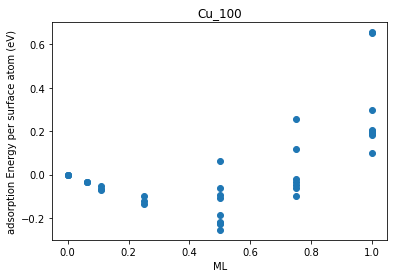

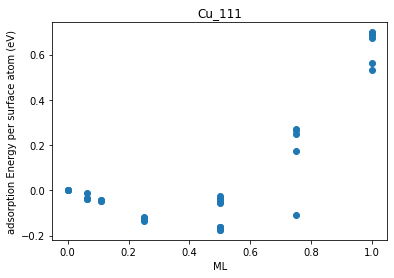

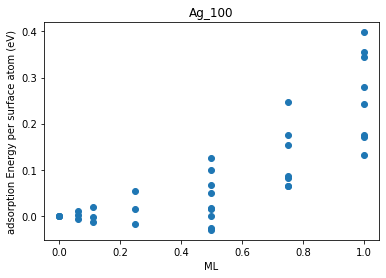

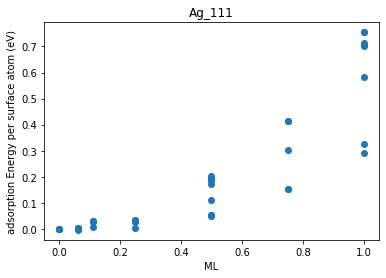

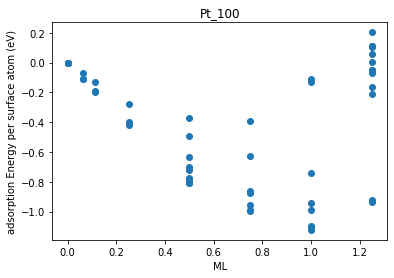

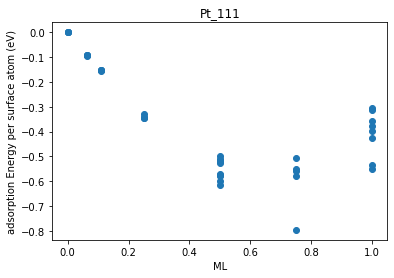

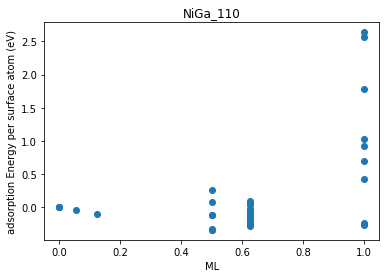

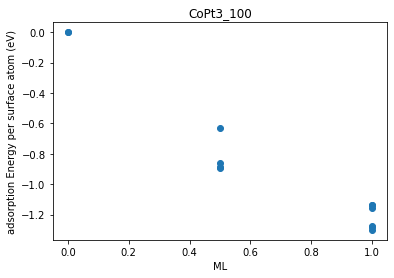

In [132]:
results = []
for dic in dictlis:
    tmp = []
    for post in collection.find(dic):
        tmp.append(post)
    results.append(tmp)

for i in range(len(results)):
    MLlis = []
    aveElis = []
    for item in results[i]:
#         print(item['name'])
        MLlis.append(item['ML'])
        aveElis.append(item['aveadsEne/suratom'])
    plt.plot(MLlis, aveElis, 'o')
    plt.title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['mirror']))
    plt.xlabel('ML')
    plt.ylabel('adsorption Energy per surface atom (eV)')
#     plt.savefig('{}_{}_ene_ML.png'.format(dictlis[i]['element'], dictlis[i]['mirror']))
    plt.show()

not eliminated the case when atoms moved to different positions

In [133]:
MLset = []
for res in results:
    tmp = []
    for item in res:
        tmp.append(item['ML'])
    MLset.append(list(set(tmp)))

In [134]:
MLset

[[0.0, 1.0, 0.75, 0.25, 0.5, 0.1111111111111111, 0.0625],
 [0.0, 1.0, 0.75, 0.25, 0.5, 0.1111111111111111, 0.0625],
 [0.0, 1.0, 0.75, 0.25, 0.5, 0.1111111111111111, 0.0625],
 [0.0, 1.0, 0.75, 0.25, 0.5, 0.1111111111111111, 0.0625],
 [0.0, 1.0, 0.5, 1.25, 0.25, 0.75, 0.1111111111111111, 0.0625],
 [0.0, 1.0, 0.75, 0.25, 0.5, 0.1111111111111111, 0.0625],
 [0.0, 0.5, 0.625, 1.0, 0.125, 0.05555555555555555],
 [0.0, 0.5, 1.0]]

In [135]:
res = []
for i in range(len(results)):
    tmp = []
    for j in range(len(MLset[i])):
        minimum = 100
        for item in results[i]:
            if item['ML'] == MLset[i][j]:
                if item['aveadsEne/suratom'] < minimum:
                    minimum = item['aveadsEne/suratom']
        tmp.append(minimum)
    res.append(tmp)

In [136]:
res

[[0.0,
  0.10004147500000116,
  -0.0967401699999968,
  -0.13751662499999995,
  -0.25547344749999823,
  -0.06950794222222277,
  -0.03446811937499916],
 [0.0,
  0.5336491150000029,
  -0.10717406499999882,
  -0.1354115974999992,
  -0.17523133749999786,
  -0.047866111111111484,
  -0.03901815999999947],
 [0.0,
  0.13163201749999942,
  0.06399907750000366,
  -0.017816384999997936,
  -0.030516254999998438,
  -0.013359536666666512,
  -0.006873164374997742],
 [0.0,
  0.29295986250000183,
  0.15194223749999836,
  0.004472172499999871,
  0.04987777250000036,
  0.005676535555555991,
  -0.00377696937500005],
 [0.0,
  -1.1234555099999994,
  -0.8113199675000011,
  -0.9358625425000042,
  -0.4190291725000037,
  -0.994912777499998,
  -0.19813297888888806,
  -0.11242980687499937],
 [0.0,
  -0.5497048050000046,
  -0.7959183449999969,
  -0.34573408500000014,
  -0.6166988475000004,
  -0.1565567466666664,
  -0.09369477312499797],
 [0.0,
  -0.3438404600000027,
  -0.2883277024999984,
  -0.2699676350000004,
  -

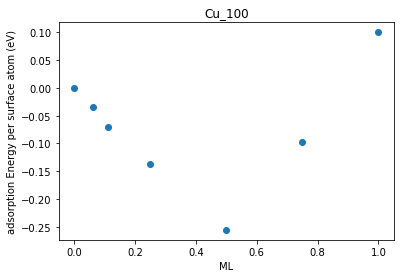

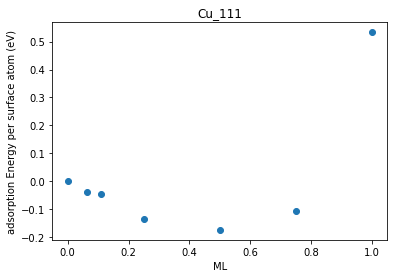

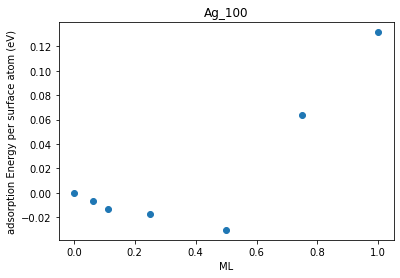

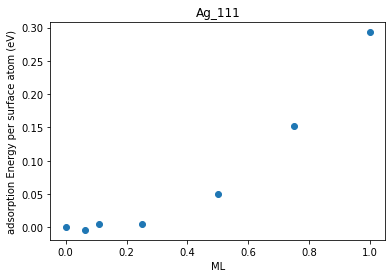

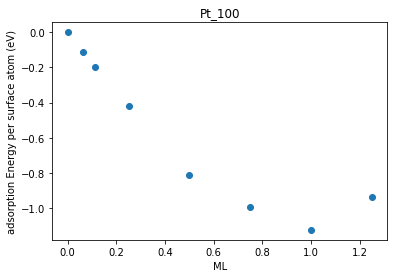

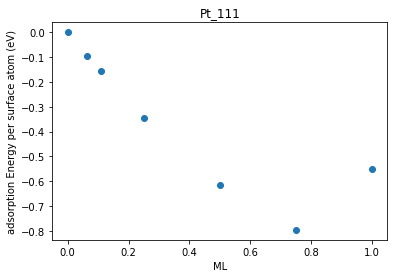

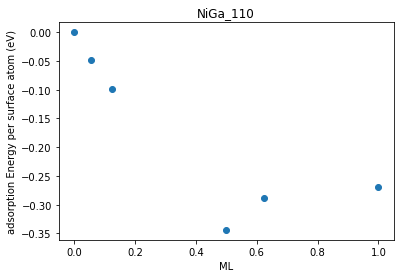

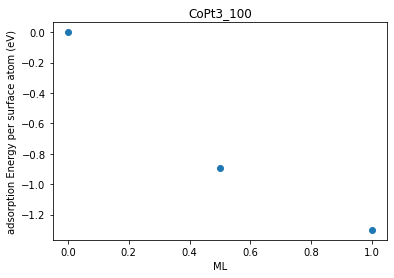

In [137]:
for i in range(len(res)):
    plt.plot(MLset[i], res[i], 'o')
    plt.title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['mirror']))
    plt.xlabel('ML')
    plt.ylabel('adsorption Energy per surface atom (eV)')
    plt.show()

In [138]:
kb = 8.62E-05 # eV/K
T = 298 # K
Pref = 1 # bar

In [139]:
prange = [0.01, 0.1, 1, 10, 100, 1000]
pres = []

for i in range(len(res)):
    tmp = []
    for p in prange:
        tmp.append(res[i]-kb*T*np.log(p/Pref)*np.array(MLset[i]))
    pres.append(tmp)

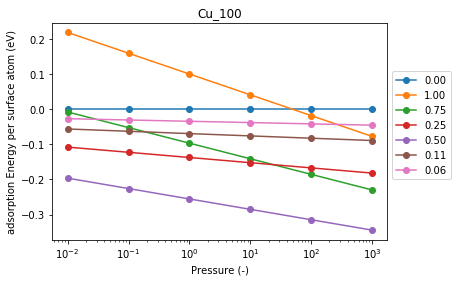

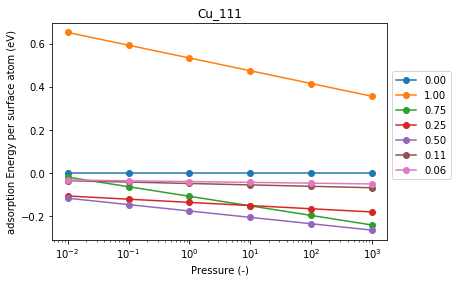

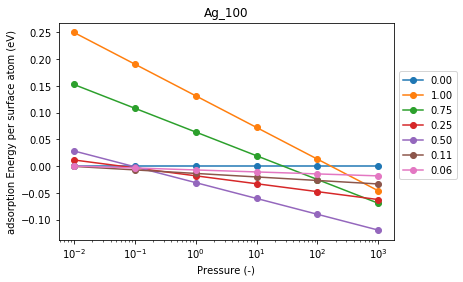

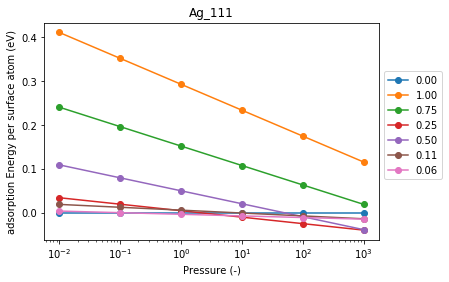

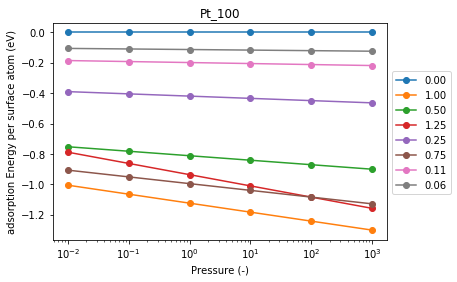

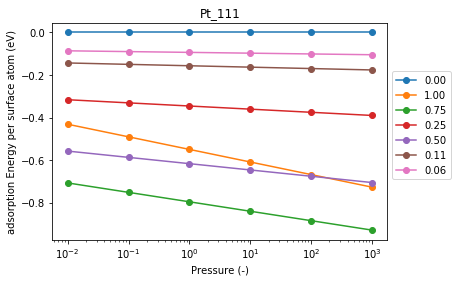

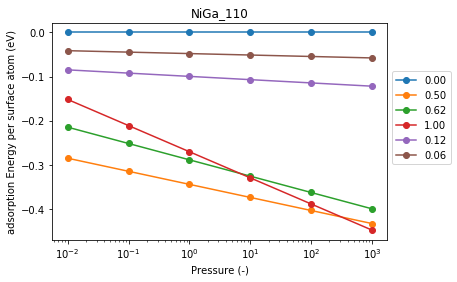

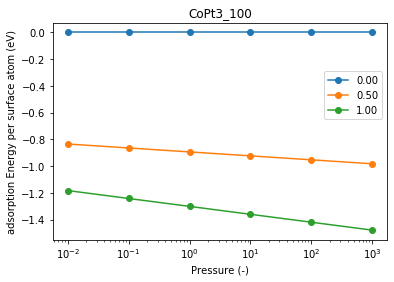

In [140]:
for i in range(len(pres)):
    plt.plot(prange, pres[i], 'o-')
    plt.xscale('log')
    plt.title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['mirror']))
    plt.xlabel('Pressure (-)')
    plt.ylabel('adsorption Energy per surface atom (eV)')
    plt.legend(['{0:.2f}'.format(item) for item in MLset[i]], bbox_to_anchor=(1, 0.8))
#     plt.savefig('{}_{}_pourbaix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']))
    plt.show()

In [144]:
items = collection.find({'element':'NiGa', 'mirror':'110', 'ML':1.0, 'aveadsEne/suratom':{"$lt":0}})

In [145]:
for item in items:
    print(item["name"])
    query(item["name"], 'local')

NiGa_110_u1_no02_CO_n2_d3.traj
NiGa_110_u1_no03_CO_n1_d3_no01_CO_n2_d3.traj
NiGa_110_u1_no03_CO_n1_d3_no03_CO_n2_d-3.traj


In [150]:
query('NiGa_110_u1_no03_CO_n1_d3_no03_CO_n2_d-3_all.traj', 'local')

Atoms(symbols='Ga2Ni2Ga2Ni2COCO', pbc=True, cell=[2.94185292, 4.1604083, 26.24061245], constraint=FixAtoms(indices=[0, 1, 2, 3]), calculator=SinglePointCalculator(...))